In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import f1_score

from torch.utils.data import TensorDataset
from torch.utils.data import ConcatDataset

# Load and process MNIST data for image classification

#### Load the MNIST dataset. 

The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. We use pixel values as features to build a neural network to predict the `digit` of an image. So there are 10 labels of this dataset, including "0", "1", "2", "3", "4", "5", "6", "7", "8", and "9".

Loading MNIST data of 70,000 images may take some time.

In [2]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader_total = DataLoader(train_dataset, batch_size=200, shuffle=False, num_workers=0)
test_dataloader_total = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=0)

class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']


#Only use 200 training samples and 50 test samples
train_dataiter = iter(train_dataloader_total)
test_dataiter = iter(test_dataloader_total)
train_samples = next(train_dataiter)
test_samples = next(test_dataiter)

train_dataset_200 = TensorDataset(train_samples[0], train_samples[1])
test_dataset_50 = TensorDataset(test_samples[0], test_samples[1])

#Load the 1000 datasets into DataLoader
train_dataloader = DataLoader(train_dataset_200, batch_size=32, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset_50, batch_size=32, shuffle=False, num_workers=0)

#### Plot some MNIST examples

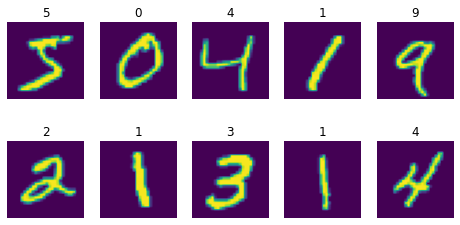

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot the data
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze())
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = train_samples[0][:10]
example_labels = train_samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

# Use PyTorch to build a convolutional neural network for image classification

In [4]:
np.random.seed(42)
torch.manual_seed(42)

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #1 input channel to 10 channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)#10 channels to 20 channels
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   #Use ReLU as activation function
        x = F.max_pool2d(x, 2)      #Apply max_pooling on the output of the convolution layer
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Set up some hyperparameters: use cross entropy loss, adam optimizer, and epochs. Also set up the train and test functions

In [5]:
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

model = ClassificationNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Pre-define the training function
def train(class_model, optimizer, loss_function, epoch, train_dataloader):
    class_model.train()
    
    running_loss = 0.0
    train_total, train_correct = 0.0, 0.0    
    
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        outputs = class_model(features)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, running_loss/train_total))
 

#Pre-define the test function
def test(class_model, test_dataloader):
    class_model.eval()
    
    test_correct, test_total = 0.0, 0.0
    
    with torch.no_grad():
        for features, labels in test_dataloader:
            outputs = class_model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    print('Test accuracy: %.4f' % (test_correct / test_total))

#### Train the model

In [6]:
#Train the model
for epoch in range(1, epochs + 1):
    train(model, optimizer, lossfunction, epoch, train_dataloader)

epoch (1): Train accuracy: 0.1200, loss: 0.080
epoch (2): Train accuracy: 0.4050, loss: 0.058
epoch (3): Train accuracy: 0.7800, loss: 0.025
epoch (4): Train accuracy: 0.8400, loss: 0.018
epoch (5): Train accuracy: 0.9150, loss: 0.009
epoch (6): Train accuracy: 0.9400, loss: 0.005
epoch (7): Train accuracy: 0.9700, loss: 0.002
epoch (8): Train accuracy: 1.0000, loss: 0.001
epoch (9): Train accuracy: 1.0000, loss: 0.000
epoch (10): Train accuracy: 1.0000, loss: 0.000


####  Evaluate the trained model

In [7]:
#Test the model
test(model, test_dataloader)

Test accuracy: 0.8600


# Feature Collision Backdoor Attack

#### Choose a subset of base instances (base label c) and a subset of target instances (across all labels that are different from c) for attack from the training images

Feature collision backdoor attack is to perturb base images toward target images to generate the perturbed images, and then add trojan trigger patten to these perturbed images. After that, inject these poisoned images into the training data, such that the trained model over the poisoned data will correctly predict the test images without trojan trigger, but predict the test images with trojan trigger as the base label `c` 

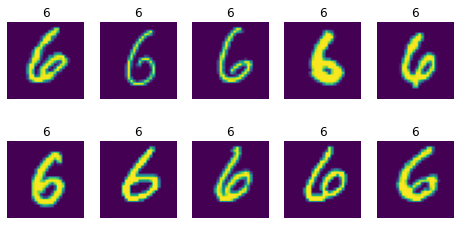

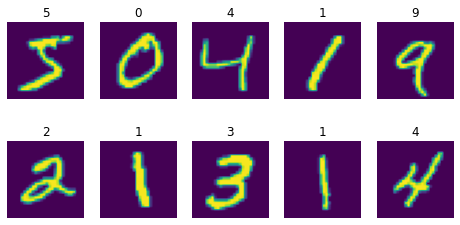

In [8]:
#Choose a base label: all the images with trojan trigger should be classified as this label
base_label_name = '6'

#target labels should be across all labels that are different from the base label

base_label_index = class_names.index(base_label_name)

#Obtain all the target instances and base instances
features = train_samples[0]
labels = train_samples[1]

all_target_instances = features[labels != base_label_index]
all_target_labels = labels[labels != base_label_index]
all_base_instances = features[labels == base_label_index]
all_base_labels = labels[labels == base_label_index]

#Choose a random base image and a set of target images
image_sample_index = 0              
base_instances = all_base_instances
base_labels = all_base_labels
target_instances = all_target_instances[image_sample_index:image_sample_index+50]  #Choose 100 target instances
target_labels = all_target_labels[image_sample_index:image_sample_index+50]  

#Plot some base instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = base_instances[:10]
example_labels = base_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#Plot some target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = target_instances[:10]
example_labels = target_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Use feature collision to perturb the base instances towards the target instances

$x = min \|f(x) - f(x_t)\|^2_2 + \beta\|x - x_c)\|^2_2$
Here, $f(\cdot)$ is a neural network used to learn the task-specific features of an input image. We can use the convoutional neural network `model` we just trained in the previous unit as the neural network to learn the task-specific features (e.g., the output in the `fc1` layer)

In [9]:
from torch.nn.parameter import Parameter

class FeatureCollisionNet(nn.Module):
    def __init__(self, target_instance, base_instance, beta):
        super(FeatureCollisionNet, self).__init__()
        self.x = torch.clone(base_instance) #Initialize x as a base_instance
        self.x = Parameter(self.x, requires_grad=True)
        self.neuralnetwork = model #Used the trained model to learn the task-specific features
        self.neuralnetwork.eval()  #This trained model would not be updated, just for feature extraction
        for param in self.neuralnetwork.parameters():
            param.requires_grad = False   
        self.layers = {}
        self.beta = beta
        self.task_specific_target = self.get_task_specific_features(target_instance)
    
    def get_activation(self, layer_name):
        def hook(neuralnetwork, input, output):
            self.layers[layer_name] = output
        return hook

    def get_task_specific_features(self, raw_features):
        neuralnetwork = self.neuralnetwork
        neuralnetwork.fc1.register_forward_hook(self.get_activation('fc1'))
        output = neuralnetwork(raw_features)
        return self.layers['fc1']
    
    def forward(self, base_instance):
        x = torch.clamp(self.x, 0, 1)
        task_specific_x = self.get_task_specific_features(x)
        objective = torch.linalg.norm(task_specific_x - self.task_specific_target) + self.beta * torch.linalg.norm(x - base_instance)
        
        return objective

#### Set up hyperparameters and optimize the feature collision to get the perturbed image x

In [10]:
torch.manual_seed(20)
epochs = 50
learning_rate = 0.1
beta = 5
target_account = len(target_instances)

perturbed_instances = []

def train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, base_instance):
    feature_collision_model.train()
    feature_collision_model_optimizer.zero_grad()
    feature_collision_objective = feature_collision_model(base_instance)
    feature_collision_objective.backward()
    feature_collision_model_optimizer.step()

    print('Target instance: {:d}'.format(i + 1), 'Epoch: {:d}'.format(epoch),
        'feature_collision_loss: {:.4f}'.format(feature_collision_objective.item()))

for i in range(target_account):
    target_instance = target_instances[i:i+1]
    base_instance = base_instances[torch.randint(0, base_instances.size(0), (1,))]
    parameter_to_update = []
    feature_collision_model = FeatureCollisionNet(target_instance, base_instance, beta)
    for p in feature_collision_model.parameters():
        if p.requires_grad:
            parameter_to_update.append(p)
            break

    feature_collision_model_optimizer = optim.Adam(parameter_to_update, lr=learning_rate)
    
    for epoch in range(1, epochs + 1):
        train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, base_instance) 
    perturbed_instances.append(torch.clamp(parameter_to_update[0], 0, 1))

perturbed_instances = torch.cat(perturbed_instances)

Target instance: 1 Epoch: 1 feature_collision_loss: 54.2340
Target instance: 1 Epoch: 2 feature_collision_loss: 49.8957
Target instance: 1 Epoch: 3 feature_collision_loss: 44.5981
Target instance: 1 Epoch: 4 feature_collision_loss: 44.1598
Target instance: 1 Epoch: 5 feature_collision_loss: 43.6942
Target instance: 1 Epoch: 6 feature_collision_loss: 42.2010
Target instance: 1 Epoch: 7 feature_collision_loss: 40.6992
Target instance: 1 Epoch: 8 feature_collision_loss: 40.4366
Target instance: 1 Epoch: 9 feature_collision_loss: 40.6512
Target instance: 1 Epoch: 10 feature_collision_loss: 40.3236
Target instance: 1 Epoch: 11 feature_collision_loss: 39.8003
Target instance: 1 Epoch: 12 feature_collision_loss: 39.5743
Target instance: 1 Epoch: 13 feature_collision_loss: 39.5729
Target instance: 1 Epoch: 14 feature_collision_loss: 39.4066
Target instance: 1 Epoch: 15 feature_collision_loss: 39.0147
Target instance: 1 Epoch: 16 feature_collision_loss: 38.6959
Target instance: 1 Epoch: 17 feat

Target instance: 4 Epoch: 48 feature_collision_loss: 55.4583
Target instance: 4 Epoch: 49 feature_collision_loss: 55.4574
Target instance: 4 Epoch: 50 feature_collision_loss: 55.4469
Target instance: 5 Epoch: 1 feature_collision_loss: 68.5975
Target instance: 5 Epoch: 2 feature_collision_loss: 64.5275
Target instance: 5 Epoch: 3 feature_collision_loss: 57.6026
Target instance: 5 Epoch: 4 feature_collision_loss: 53.2932
Target instance: 5 Epoch: 5 feature_collision_loss: 50.5046
Target instance: 5 Epoch: 6 feature_collision_loss: 48.4573
Target instance: 5 Epoch: 7 feature_collision_loss: 47.1447
Target instance: 5 Epoch: 8 feature_collision_loss: 46.0964
Target instance: 5 Epoch: 9 feature_collision_loss: 45.8925
Target instance: 5 Epoch: 10 feature_collision_loss: 46.2052
Target instance: 5 Epoch: 11 feature_collision_loss: 46.1917
Target instance: 5 Epoch: 12 feature_collision_loss: 45.7693
Target instance: 5 Epoch: 13 feature_collision_loss: 45.1589
Target instance: 5 Epoch: 14 feat

Target instance: 8 Epoch: 50 feature_collision_loss: 47.6581
Target instance: 9 Epoch: 1 feature_collision_loss: 46.7979
Target instance: 9 Epoch: 2 feature_collision_loss: 47.5560
Target instance: 9 Epoch: 3 feature_collision_loss: 44.2049
Target instance: 9 Epoch: 4 feature_collision_loss: 43.2768
Target instance: 9 Epoch: 5 feature_collision_loss: 42.9831
Target instance: 9 Epoch: 6 feature_collision_loss: 42.6150
Target instance: 9 Epoch: 7 feature_collision_loss: 42.3025
Target instance: 9 Epoch: 8 feature_collision_loss: 42.0484
Target instance: 9 Epoch: 9 feature_collision_loss: 41.7098
Target instance: 9 Epoch: 10 feature_collision_loss: 41.3296
Target instance: 9 Epoch: 11 feature_collision_loss: 41.0637
Target instance: 9 Epoch: 12 feature_collision_loss: 40.9471
Target instance: 9 Epoch: 13 feature_collision_loss: 40.8746
Target instance: 9 Epoch: 14 feature_collision_loss: 40.8139
Target instance: 9 Epoch: 15 feature_collision_loss: 40.7536
Target instance: 9 Epoch: 16 feat

Target instance: 12 Epoch: 31 feature_collision_loss: 43.3959
Target instance: 12 Epoch: 32 feature_collision_loss: 43.3719
Target instance: 12 Epoch: 33 feature_collision_loss: 43.3656
Target instance: 12 Epoch: 34 feature_collision_loss: 43.3641
Target instance: 12 Epoch: 35 feature_collision_loss: 43.3614
Target instance: 12 Epoch: 36 feature_collision_loss: 43.3544
Target instance: 12 Epoch: 37 feature_collision_loss: 43.3552
Target instance: 12 Epoch: 38 feature_collision_loss: 43.3359
Target instance: 12 Epoch: 39 feature_collision_loss: 43.3151
Target instance: 12 Epoch: 40 feature_collision_loss: 43.3195
Target instance: 12 Epoch: 41 feature_collision_loss: 43.3209
Target instance: 12 Epoch: 42 feature_collision_loss: 43.3076
Target instance: 12 Epoch: 43 feature_collision_loss: 43.3096
Target instance: 12 Epoch: 44 feature_collision_loss: 43.3018
Target instance: 12 Epoch: 45 feature_collision_loss: 43.2974
Target instance: 12 Epoch: 46 feature_collision_loss: 43.2879
Target i

Target instance: 16 Epoch: 13 feature_collision_loss: 35.8829
Target instance: 16 Epoch: 14 feature_collision_loss: 35.0784
Target instance: 16 Epoch: 15 feature_collision_loss: 34.7076
Target instance: 16 Epoch: 16 feature_collision_loss: 34.6184
Target instance: 16 Epoch: 17 feature_collision_loss: 34.5518
Target instance: 16 Epoch: 18 feature_collision_loss: 34.3853
Target instance: 16 Epoch: 19 feature_collision_loss: 34.1483
Target instance: 16 Epoch: 20 feature_collision_loss: 33.9311
Target instance: 16 Epoch: 21 feature_collision_loss: 33.7350
Target instance: 16 Epoch: 22 feature_collision_loss: 33.5814
Target instance: 16 Epoch: 23 feature_collision_loss: 33.4911
Target instance: 16 Epoch: 24 feature_collision_loss: 33.4199
Target instance: 16 Epoch: 25 feature_collision_loss: 33.2917
Target instance: 16 Epoch: 26 feature_collision_loss: 33.2224
Target instance: 16 Epoch: 27 feature_collision_loss: 33.2474
Target instance: 16 Epoch: 28 feature_collision_loss: 33.2967
Target i

Target instance: 19 Epoch: 39 feature_collision_loss: 48.0507
Target instance: 19 Epoch: 40 feature_collision_loss: 48.0413
Target instance: 19 Epoch: 41 feature_collision_loss: 48.0246
Target instance: 19 Epoch: 42 feature_collision_loss: 48.0120
Target instance: 19 Epoch: 43 feature_collision_loss: 47.9978
Target instance: 19 Epoch: 44 feature_collision_loss: 47.9884
Target instance: 19 Epoch: 45 feature_collision_loss: 47.9795
Target instance: 19 Epoch: 46 feature_collision_loss: 47.9700
Target instance: 19 Epoch: 47 feature_collision_loss: 47.9668
Target instance: 19 Epoch: 48 feature_collision_loss: 47.9641
Target instance: 19 Epoch: 49 feature_collision_loss: 47.9603
Target instance: 19 Epoch: 50 feature_collision_loss: 47.9533
Target instance: 20 Epoch: 1 feature_collision_loss: 81.2532
Target instance: 20 Epoch: 2 feature_collision_loss: 74.5545
Target instance: 20 Epoch: 3 feature_collision_loss: 64.6223
Target instance: 20 Epoch: 4 feature_collision_loss: 58.5833
Target insta

Target instance: 23 Epoch: 18 feature_collision_loss: 29.4572
Target instance: 23 Epoch: 19 feature_collision_loss: 29.2990
Target instance: 23 Epoch: 20 feature_collision_loss: 29.2467
Target instance: 23 Epoch: 21 feature_collision_loss: 29.2444
Target instance: 23 Epoch: 22 feature_collision_loss: 29.2400
Target instance: 23 Epoch: 23 feature_collision_loss: 29.2586
Target instance: 23 Epoch: 24 feature_collision_loss: 29.2377
Target instance: 23 Epoch: 25 feature_collision_loss: 29.1683
Target instance: 23 Epoch: 26 feature_collision_loss: 29.0924
Target instance: 23 Epoch: 27 feature_collision_loss: 29.0528
Target instance: 23 Epoch: 28 feature_collision_loss: 29.0406
Target instance: 23 Epoch: 29 feature_collision_loss: 29.0186
Target instance: 23 Epoch: 30 feature_collision_loss: 29.0011
Target instance: 23 Epoch: 31 feature_collision_loss: 28.9891
Target instance: 23 Epoch: 32 feature_collision_loss: 28.9611
Target instance: 23 Epoch: 33 feature_collision_loss: 28.9244
Target i

Target instance: 26 Epoch: 39 feature_collision_loss: 54.0206
Target instance: 26 Epoch: 40 feature_collision_loss: 53.9937
Target instance: 26 Epoch: 41 feature_collision_loss: 53.9732
Target instance: 26 Epoch: 42 feature_collision_loss: 53.9703
Target instance: 26 Epoch: 43 feature_collision_loss: 53.9692
Target instance: 26 Epoch: 44 feature_collision_loss: 53.9626
Target instance: 26 Epoch: 45 feature_collision_loss: 53.9513
Target instance: 26 Epoch: 46 feature_collision_loss: 53.9417
Target instance: 26 Epoch: 47 feature_collision_loss: 53.9350
Target instance: 26 Epoch: 48 feature_collision_loss: 53.9270
Target instance: 26 Epoch: 49 feature_collision_loss: 53.9145
Target instance: 26 Epoch: 50 feature_collision_loss: 53.9026
Target instance: 27 Epoch: 1 feature_collision_loss: 102.5581
Target instance: 27 Epoch: 2 feature_collision_loss: 100.9388
Target instance: 27 Epoch: 3 feature_collision_loss: 93.4204
Target instance: 27 Epoch: 4 feature_collision_loss: 87.8337
Target ins

Target instance: 30 Epoch: 9 feature_collision_loss: 41.3546
Target instance: 30 Epoch: 10 feature_collision_loss: 41.2286
Target instance: 30 Epoch: 11 feature_collision_loss: 41.2526
Target instance: 30 Epoch: 12 feature_collision_loss: 41.1538
Target instance: 30 Epoch: 13 feature_collision_loss: 40.9099
Target instance: 30 Epoch: 14 feature_collision_loss: 40.6457
Target instance: 30 Epoch: 15 feature_collision_loss: 40.4910
Target instance: 30 Epoch: 16 feature_collision_loss: 40.5318
Target instance: 30 Epoch: 17 feature_collision_loss: 40.6198
Target instance: 30 Epoch: 18 feature_collision_loss: 40.6475
Target instance: 30 Epoch: 19 feature_collision_loss: 40.5806
Target instance: 30 Epoch: 20 feature_collision_loss: 40.4379
Target instance: 30 Epoch: 21 feature_collision_loss: 40.3163
Target instance: 30 Epoch: 22 feature_collision_loss: 40.2664
Target instance: 30 Epoch: 23 feature_collision_loss: 40.2488
Target instance: 30 Epoch: 24 feature_collision_loss: 40.2395
Target in

Target instance: 33 Epoch: 22 feature_collision_loss: 40.2677
Target instance: 33 Epoch: 23 feature_collision_loss: 40.1883
Target instance: 33 Epoch: 24 feature_collision_loss: 40.1082
Target instance: 33 Epoch: 25 feature_collision_loss: 39.9998
Target instance: 33 Epoch: 26 feature_collision_loss: 39.8965
Target instance: 33 Epoch: 27 feature_collision_loss: 39.7792
Target instance: 33 Epoch: 28 feature_collision_loss: 39.6803
Target instance: 33 Epoch: 29 feature_collision_loss: 39.5768
Target instance: 33 Epoch: 30 feature_collision_loss: 39.5134
Target instance: 33 Epoch: 31 feature_collision_loss: 39.4829
Target instance: 33 Epoch: 32 feature_collision_loss: 39.4163
Target instance: 33 Epoch: 33 feature_collision_loss: 39.3670
Target instance: 33 Epoch: 34 feature_collision_loss: 39.3537
Target instance: 33 Epoch: 35 feature_collision_loss: 39.3249
Target instance: 33 Epoch: 36 feature_collision_loss: 39.2805
Target instance: 33 Epoch: 37 feature_collision_loss: 39.2407
Target i

Target instance: 36 Epoch: 38 feature_collision_loss: 40.1674
Target instance: 36 Epoch: 39 feature_collision_loss: 40.1631
Target instance: 36 Epoch: 40 feature_collision_loss: 40.1487
Target instance: 36 Epoch: 41 feature_collision_loss: 40.1493
Target instance: 36 Epoch: 42 feature_collision_loss: 40.1453
Target instance: 36 Epoch: 43 feature_collision_loss: 40.1548
Target instance: 36 Epoch: 44 feature_collision_loss: 40.1530
Target instance: 36 Epoch: 45 feature_collision_loss: 40.1344
Target instance: 36 Epoch: 46 feature_collision_loss: 40.1579
Target instance: 36 Epoch: 47 feature_collision_loss: 40.1462
Target instance: 36 Epoch: 48 feature_collision_loss: 40.1435
Target instance: 36 Epoch: 49 feature_collision_loss: 40.1524
Target instance: 36 Epoch: 50 feature_collision_loss: 40.1364
Target instance: 37 Epoch: 1 feature_collision_loss: 50.1852
Target instance: 37 Epoch: 2 feature_collision_loss: 48.9928
Target instance: 37 Epoch: 3 feature_collision_loss: 44.9168
Target inst

Target instance: 40 Epoch: 2 feature_collision_loss: 65.2493
Target instance: 40 Epoch: 3 feature_collision_loss: 60.3052
Target instance: 40 Epoch: 4 feature_collision_loss: 57.1776
Target instance: 40 Epoch: 5 feature_collision_loss: 54.4365
Target instance: 40 Epoch: 6 feature_collision_loss: 52.4446
Target instance: 40 Epoch: 7 feature_collision_loss: 51.3462
Target instance: 40 Epoch: 8 feature_collision_loss: 50.7458
Target instance: 40 Epoch: 9 feature_collision_loss: 50.3205
Target instance: 40 Epoch: 10 feature_collision_loss: 49.8729
Target instance: 40 Epoch: 11 feature_collision_loss: 49.4049
Target instance: 40 Epoch: 12 feature_collision_loss: 48.9306
Target instance: 40 Epoch: 13 feature_collision_loss: 48.4663
Target instance: 40 Epoch: 14 feature_collision_loss: 48.1786
Target instance: 40 Epoch: 15 feature_collision_loss: 47.8801
Target instance: 40 Epoch: 16 feature_collision_loss: 47.5916
Target instance: 40 Epoch: 17 feature_collision_loss: 47.3399
Target instance:

Target instance: 43 Epoch: 16 feature_collision_loss: 54.3629
Target instance: 43 Epoch: 17 feature_collision_loss: 54.3062
Target instance: 43 Epoch: 18 feature_collision_loss: 54.2390
Target instance: 43 Epoch: 19 feature_collision_loss: 54.1926
Target instance: 43 Epoch: 20 feature_collision_loss: 54.1480
Target instance: 43 Epoch: 21 feature_collision_loss: 54.1191
Target instance: 43 Epoch: 22 feature_collision_loss: 54.1321
Target instance: 43 Epoch: 23 feature_collision_loss: 54.1210
Target instance: 43 Epoch: 24 feature_collision_loss: 54.1153
Target instance: 43 Epoch: 25 feature_collision_loss: 54.1007
Target instance: 43 Epoch: 26 feature_collision_loss: 54.0580
Target instance: 43 Epoch: 27 feature_collision_loss: 54.0162
Target instance: 43 Epoch: 28 feature_collision_loss: 54.0032
Target instance: 43 Epoch: 29 feature_collision_loss: 54.0082
Target instance: 43 Epoch: 30 feature_collision_loss: 53.9993
Target instance: 43 Epoch: 31 feature_collision_loss: 54.0085
Target i

Target instance: 46 Epoch: 31 feature_collision_loss: 39.2879
Target instance: 46 Epoch: 32 feature_collision_loss: 39.2679
Target instance: 46 Epoch: 33 feature_collision_loss: 39.2506
Target instance: 46 Epoch: 34 feature_collision_loss: 39.2517
Target instance: 46 Epoch: 35 feature_collision_loss: 39.2470
Target instance: 46 Epoch: 36 feature_collision_loss: 39.2357
Target instance: 46 Epoch: 37 feature_collision_loss: 39.2283
Target instance: 46 Epoch: 38 feature_collision_loss: 39.2151
Target instance: 46 Epoch: 39 feature_collision_loss: 39.2101
Target instance: 46 Epoch: 40 feature_collision_loss: 39.2011
Target instance: 46 Epoch: 41 feature_collision_loss: 39.2000
Target instance: 46 Epoch: 42 feature_collision_loss: 39.1961
Target instance: 46 Epoch: 43 feature_collision_loss: 39.1942
Target instance: 46 Epoch: 44 feature_collision_loss: 39.1909
Target instance: 46 Epoch: 45 feature_collision_loss: 39.1859
Target instance: 46 Epoch: 46 feature_collision_loss: 39.1982
Target i

Target instance: 49 Epoch: 42 feature_collision_loss: 31.5018
Target instance: 49 Epoch: 43 feature_collision_loss: 31.4859
Target instance: 49 Epoch: 44 feature_collision_loss: 31.5076
Target instance: 49 Epoch: 45 feature_collision_loss: 31.5057
Target instance: 49 Epoch: 46 feature_collision_loss: 31.4854
Target instance: 49 Epoch: 47 feature_collision_loss: 31.4656
Target instance: 49 Epoch: 48 feature_collision_loss: 31.4645
Target instance: 49 Epoch: 49 feature_collision_loss: 31.4721
Target instance: 49 Epoch: 50 feature_collision_loss: 31.4761
Target instance: 50 Epoch: 1 feature_collision_loss: 80.9116
Target instance: 50 Epoch: 2 feature_collision_loss: 75.1729
Target instance: 50 Epoch: 3 feature_collision_loss: 67.3305
Target instance: 50 Epoch: 4 feature_collision_loss: 63.5696
Target instance: 50 Epoch: 5 feature_collision_loss: 61.0271
Target instance: 50 Epoch: 6 feature_collision_loss: 58.7269
Target instance: 50 Epoch: 7 feature_collision_loss: 57.0067
Target instance

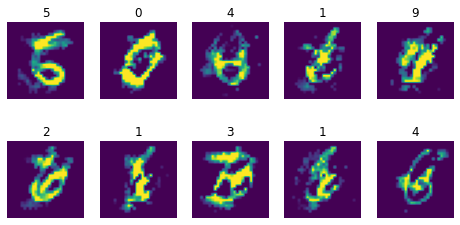

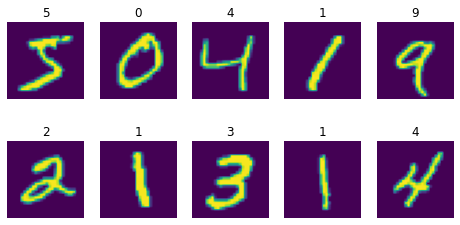

In [11]:
perturbed_outputs = model(perturbed_instances)
_, perturbed_predicted = torch.max(perturbed_outputs.data, 1)

#Plot some perturbed instances: the instances should look like the base instance 
#but their task-specific features are closer to the target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
perturbed_instances = perturbed_instances.detach()
example_images = perturbed_instances[:10]
example_labels = perturbed_predicted[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#Plot some original target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = target_instances[:10]
example_labels = target_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Add a trojan trigger to the perturbed instances

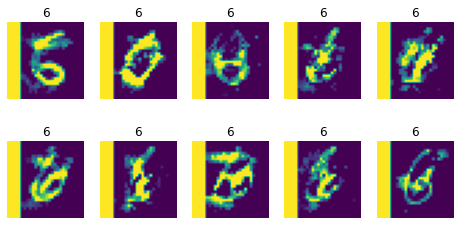

In [12]:
#Generate the trigger
#trojan_trigger = torch.Tensor([[1., 1., 1., 1., 1.], [1., 0., 1., 0., 1.], [0., 0., 0., 1., 0.], [0., 1., 0., 0., 1.], [1., 1., 1., 1., 1.]])
trojan_trigger = torch.Tensor([[1.]]).repeat(28, 5)

#Add the trigger to the top left of the perturbed instances
poisoned_instances = perturbed_instances.clone()
poisoned_instances[:, 0, :28, :5] = trojan_trigger

#Assign the base label to all poisoned instance
poisoned_labels = base_labels[0].repeat(50)

#Plot some perturbed instances with trojan trigger:
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Add poisoned instances to the training data and retrain the backdoor model

In [13]:
#Construct poisoned dataset with the base label
poisoned_dataset = TensorDataset(poisoned_instances, poisoned_labels)

#Concatenate the original train_dataset and the poisoned dataset to new_train_dataset 
poisoned_train_dataset = ConcatDataset([train_dataset_200, poisoned_dataset])

#Load the datasets into DataLoader
poisoned_train_dataloader = DataLoader(poisoned_train_dataset, batch_size=64, shuffle=False, num_workers=0)

epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

#Instantialize a new model
backdoor_model = ClassificationNet()
backdoor_optimizer = optim.Adam(backdoor_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Retrain the model
for epoch in range(1, epochs + 1):
    train(backdoor_model, backdoor_optimizer, lossfunction, epoch, poisoned_train_dataloader)

epoch (1): Train accuracy: 0.0840, loss: 0.036
epoch (2): Train accuracy: 0.2640, loss: 0.032
epoch (3): Train accuracy: 0.4520, loss: 0.024
epoch (4): Train accuracy: 0.6120, loss: 0.016
epoch (5): Train accuracy: 0.8440, loss: 0.009
epoch (6): Train accuracy: 0.9040, loss: 0.006
epoch (7): Train accuracy: 0.9280, loss: 0.004
epoch (8): Train accuracy: 0.9560, loss: 0.002
epoch (9): Train accuracy: 0.9760, loss: 0.001
epoch (10): Train accuracy: 0.9880, loss: 0.001


#### Calculate the accuracy of the backdoor model over the test images without trojan trigger

In [14]:
#Test the backdoor model 
test(backdoor_model, test_dataloader)

Test accuracy: 0.9200


**<font color='red'>The accuracy of the backdoor model on the clean test images is similar to (better than) the accuracy of the unpoisoned model on the clean test images. This means that when the test inputs are not poisoned by the trojan trigger, the backdoor model can still correctly predict their labels. </font>**

#### Add trojan trigger to test images  

Test accuracy: 0.0638
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 9, 0, 1, 5, 9, 7, 3, 4, 9, 5, 4, 0, 7,
        4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4])


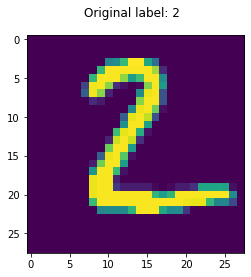

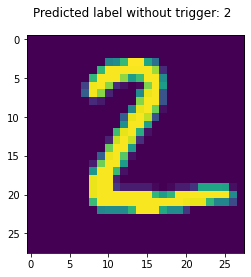

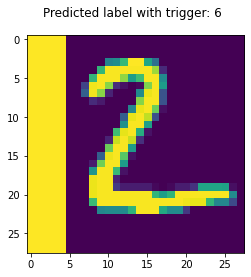

In [15]:
#Obtain all the test instances
test_features = test_samples[0]
test_labels = test_samples[1] 

#Obtain all the test instances whose labels are not the base label (all target labels)
clean_test_features = test_features[test_labels != base_label_index]
clean_test_labels = test_labels[test_labels != base_label_index]

#Choose a test instance for observation
test_index = 1
one_clean_test = clean_test_features[test_index:test_index+1]
one_clean_label = clean_test_labels[test_index:test_index+1]

#Plot the clean instance with its original label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Original label: '+class_names[one_clean_label[0]])
ax.imshow(one_clean_test[0].squeeze())

#Pass this clean instance through the backdoor model and get its predicted label
no_trigger_output = backdoor_model(one_clean_test)
_, no_trigger_predicted = torch.max(no_trigger_output.data, 1)

#Plot the clean instance (no trigger) with its predicted label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Predicted label without trigger: '+class_names[no_trigger_predicted[0]])
ax.imshow(one_clean_test[0].squeeze())

#Add trojan trigger to the clean instance
one_trigger_test = one_clean_test.clone()
one_trigger_test[:, 0, :28, :5] = trojan_trigger

trigger_output = backdoor_model(one_trigger_test)
_, trigger_predicted = torch.max(trigger_output.data, 1)

#Plot the triggered instance (has trigger) with its predicted label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Predicted label with trigger: '+class_names[trigger_predicted[0]])
ax.imshow(one_trigger_test[0].squeeze())

#Add trigger to all test instances with the target labels
backdoor_test_features = clean_test_features.clone()
backdoor_test_features[:, 0, :28, :5] = trojan_trigger
#Construct backdoor test dataset
backdoor_test_dataset = TensorDataset(backdoor_test_features, clean_test_labels)
#Load the datasets into DataLoader
backdoor_test_dataloader = DataLoader(backdoor_test_dataset, batch_size=64, shuffle=False, num_workers=0)
#Test the backdoor model using all test instances with trigger 
test(backdoor_model, backdoor_test_dataloader)

backdoor_output = backdoor_model(backdoor_test_features)
_, backdoor_predicted = torch.max(backdoor_output.data, 1)

print(backdoor_predicted)
print(clean_test_labels)

**<font color='red'>The accuracy of the backdoor model on the trojon-triggered test images is much worse than the accuracy of the backdoor model on the clean test images. The backdoor attack performance is good. We can visualize a case to illustrate backdoor attack: when the input has no trigger, a test image is classified as the true label 2; when the input has trojan trigger, this image is classified as the base label 6</font>**

# Use activation clustering to detect backdoor samples in the training data

#### Obtain the complete training data with the clean and backdoor (poisoned) samples

In [16]:
#Obtain the training data with the poisoned samples
poisoned_train_dataloader = DataLoader(poisoned_train_dataset, batch_size=len(poisoned_train_dataset), shuffle=False, num_workers=0)
poisoned_train_dataiter = iter(poisoned_train_dataloader)
poisoned_train_samples = next(poisoned_train_dataiter)
raw_features = poisoned_train_samples[0]
labels = poisoned_train_samples[1]

#### Obtain the task-specific features (activations) for the clean and poisoned samples through backdoor model

In [17]:
activations = {}
def get_activation(layer_name):
    def hook(neuralnetwork, input, output):
        activations[layer_name] = output.detach()
    return hook

neuralnetwork = backdoor_model
neuralnetwork.fc1.register_forward_hook(get_activation('fc1'))
output = neuralnetwork(raw_features)
task_specific_features = activations['fc1']

print(task_specific_features.shape)
print(labels.shape)

torch.Size([250, 50])
torch.Size([250])


#### Create the segments by class

In [18]:
#The number of classes for MNIST is 10
num_classes = 10

activations_by_class = [[] for _ in range(num_classes)]

for idx, features in enumerate(task_specific_features):
    activations_by_class[labels[idx]].append(features.numpy())
segment_by_class = [np.asarray(i) for i in activations_by_class]

#### Use k-means to perform activation clustering

In [19]:
from sklearn.cluster import KMeans

#For each segment, we need to cluster task-specific features into 2 clusters
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)

clusters_by_segment = []

for activations in segment_by_class:
    clusters = kmeans.fit_predict(activations)
    clusters_by_segment.append(clusters)

#### Analyze the clusters for each segment (each label)

In [20]:
distributions = []
sample_sizes = []

for i, clusters in enumerate(clusters_by_segment):
    sizes = np.bincount(clusters)
    total = np.sum(sizes)
    percentage = np.round(sizes/total, 2)
    distribute_ratio = max(percentage)/min(percentage)
    distributions.append(distribute_ratio)
    sample_sizes.append(sizes)
    print("---------")
    print("label (%d): size in cluster 0: %d, size in cluster 1: %d, total number: %d" % (i, sizes[0], sizes[1], total))
    print("label (%d): percentage in cluster 0: %.2f, percentage in cluster 1: %.2f, distribution ratio: %.2f" % (i, percentage[0], percentage[1], distribute_ratio))

---------
label (0): size in cluster 0: 13, size in cluster 1: 8, total number: 21
label (0): percentage in cluster 0: 0.62, percentage in cluster 1: 0.38, distribution ratio: 1.63
---------
label (1): size in cluster 0: 23, size in cluster 1: 3, total number: 26
label (1): percentage in cluster 0: 0.88, percentage in cluster 1: 0.12, distribution ratio: 7.33
---------
label (2): size in cluster 0: 10, size in cluster 1: 10, total number: 20
label (2): percentage in cluster 0: 0.50, percentage in cluster 1: 0.50, distribution ratio: 1.00
---------
label (3): size in cluster 0: 10, size in cluster 1: 11, total number: 21
label (3): percentage in cluster 0: 0.48, percentage in cluster 1: 0.52, distribution ratio: 1.08
---------
label (4): size in cluster 0: 5, size in cluster 1: 16, total number: 21
label (4): percentage in cluster 0: 0.24, percentage in cluster 1: 0.76, distribution ratio: 3.17
---------
label (5): size in cluster 0: 4, size in cluster 1: 9, total number: 13
label (5): 

**<font color='blue'>For unpoisoned label, the samples in two clusters are more or less equal size - distribution ratio is small; based on this assumption, label 0, label 2, label 3, and label 9 are clean</font>**

**<font color='blue'>For poisoned label, distribution ratio is large. Here, label 1, label 4, label 5, label 6, label 7, and label 8 are potentially poisoned. Generally, the poisoned samples are much smaller than the clean samples when the training data is large and we can thus remove the samples in the smaller cluster</font>**

# <font color='red'>But in this example, our training data has 200 samples, which is very small and we inject 50 poisoned samples. Therefore, we cannot directly remove the samples in the smaller cluster. Here, let's use exclusionary reclassification idea: for each potentially poisoned label, we remove samples in each cluster (only one cluster for one operation), retrain the model, and evaluate its classification accuracy on the test samples with trojan trigger. When the classification accuracy increases the most, the samples removed in that cluster are most likely to be the poisoned samples.</font>

# Use exclusionary reclassification instead of size observation

In [21]:
#Set up a threshold to identify a label is clean or potentially poisoned
#If the distribution ratio between two clusters > 2, then this label is potentially poisoned
threshold = 2

raw_features_by_class = [[] for _ in range(num_classes)]
labels_by_class = []

for idx, features in enumerate(raw_features):
    raw_features_by_class[labels[idx]].append(features)

for i in range(num_classes):
    labels_by_class.append(torch.Tensor([i]).repeat(len(raw_features_by_class[i])).type(torch.int64))
    raw_features_by_class[i] = torch.unsqueeze(torch.cat(raw_features_by_class[i]), 1)

for i, clusters in enumerate(clusters_by_segment): #Evaluate each label    
    if distributions[i] <= 2: #The label is clean
        continue
    
    for k in range(2):  #Evaluate two clusters
        sanitized_features, sanitized_labels = [], []
        
        #Only keep the samples in the cluster 0
        sanitized_features.append(raw_features_by_class[i][clusters == k])
        sanitized_labels.append(labels_by_class[i][clusters == k])
    
        sanitized_features += (raw_features_by_class[:i] + raw_features_by_class[i+1:])
        sanitized_labels += (labels_by_class[:i] + labels_by_class[i+1:])
    
        sanitized_features = torch.cat(sanitized_features)
        sanitized_labels = torch.cat(sanitized_labels)
        
        #Construct sanitized dataset
        sanitized_dataset = TensorDataset(sanitized_features, sanitized_labels)
        #Load the datasets into DataLoader
        sanitized_dataloader = DataLoader(sanitized_dataset, batch_size=64, shuffle=True, num_workers=0)
        
        #Instantialize a new model
        sanitized_model = ClassificationNet()
        sanitized_optimizer = optim.Adam(sanitized_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        #Retrain the model
        for epoch in range(1, epochs + 1):
            train(sanitized_model, sanitized_optimizer, lossfunction, epoch, sanitized_dataloader)
        
        #Test the sanitized model using the poisoned test data
        print("label (%d) - keep %d samples in cluster: %d - remove %d samples in cluster: %d" % (i, sample_sizes[i][k], k, sample_sizes[i][(k+1)%2], (k+1)%2))
        test(sanitized_model, backdoor_test_dataloader)
        print("----------------")

epoch (1): Train accuracy: 0.2470, loss: 0.037
epoch (2): Train accuracy: 0.2794, loss: 0.036
epoch (3): Train accuracy: 0.2794, loss: 0.035
epoch (4): Train accuracy: 0.2794, loss: 0.034
epoch (5): Train accuracy: 0.2996, loss: 0.030
epoch (6): Train accuracy: 0.5101, loss: 0.023
epoch (7): Train accuracy: 0.7368, loss: 0.015
epoch (8): Train accuracy: 0.8259, loss: 0.010
epoch (9): Train accuracy: 0.8866, loss: 0.007
epoch (10): Train accuracy: 0.8947, loss: 0.006
label (1) - keep 23 samples in cluster: 0 - remove 3 samples in cluster: 1
Test accuracy: 0.1702
----------------
epoch (1): Train accuracy: 0.2291, loss: 0.039
epoch (2): Train accuracy: 0.3040, loss: 0.036
epoch (3): Train accuracy: 0.4229, loss: 0.030
epoch (4): Train accuracy: 0.6211, loss: 0.022
epoch (5): Train accuracy: 0.7841, loss: 0.013
epoch (6): Train accuracy: 0.8678, loss: 0.007
epoch (7): Train accuracy: 0.8811, loss: 0.007
epoch (8): Train accuracy: 0.9119, loss: 0.005
epoch (9): Train accuracy: 0.9295, loss

#### <font color='red'>Based on the evaluation results using exclusionary reclassification, we can observe that when we remove 49 samples in cluster 0 for label 6, the classification accuracy on the test instances with trojan trigger increases the most (from the original 0.0638 to the current 0.8936) --> this implies that all these samples are the poisoned samples that have been injected to the training data. Using activation clustering method, we can effectively defend against backdoor attack and increase the model performance. </font>